# Hypothesis Testing

In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats.distributions as dist

In [18]:
da = pd.read_csv("nhanes_2015_2016.csv")

da["SMQ020x"] = da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})  # np.nan represents a missing value
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})
da["DMDCITZNx"] = da.DMDCITZN.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})

### Hypothesis tests for single proportions - smoking rate

In [19]:
x = da.SMQ020x.dropna() == "Yes"
p = x.mean()
se = np.sqrt(0.4 * 0.6 / len(x))
test_stat = (p - 0.4) / se
pvalue = 2*dist.norm.cdf(-np.abs(test_stat))
print(test_stat, pvalue)

0.7823563854332805 0.4340051581348052


The (two-sided) one-sample test that the population proportion of smokers is 0.4, and obtain a p-value of 0.43.  This indicates that the NHANES data are compatible with the proportion of (ever) smokers in the US being 40%. 

The following cell carries out the same test as performed above using the Statsmodels library.

In [27]:
print(sm.stats.proportions_ztest(x.sum(), len(x), 0.4)) # Normal approximation with estimated proportion in SE
print(sm.stats.proportions_ztest(x.sum(), len(x), 0.4, prop_var=0.4)) # Normal approximation with null proportion in SE

print(sm.stats.binom_test(x.sum(), len(x), 0.4)) # Exact binomial p-value

(0.7807518954896244, 0.43494843171868214)
(0.7823563854332805, 0.4340051581348052)
0.43403608544100336


### Hypothesis tests for two proportions - smoking rates

In [28]:
dx = da[["SMQ020x", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 20) & (dx.RIDAGEYR <= 25), :] # Restrict to people between 20 and 25 years old

# Summarize the data by caclculating the proportion of yes responses and the sample size
p = dx.groupby("RIAGENDRx")["SMQ020x"].agg([lambda z: np.mean(z=="Yes"), "size"])
p.columns = ["Smoke", "N"]
print(p)

# The pooled rate of yes responses, and the standard error
p_comb = (dx.SMQ020x == "Yes").mean()
va = p_comb * (1 - p_comb)
se = np.sqrt(va * (1 / p.N.Female + 1 / p.N.Male))

test_stat = (p.Smoke.Female - p.Smoke.Male) / se
pvalue = 2*dist.norm.cdf(-np.abs(test_stat))
print(test_stat, pvalue)

              Smoke    N
RIAGENDRx               
Female     0.238971  272
Male       0.341270  252
-2.5833303066279414 0.009785159057508375


The smoking rate for men is around 10 percentage points greater than the smoking rate for females, and this difference is statistically significant (the p-value is around 0.01).

### Hypothesis tests comparing means - systolic blood pressure

Comparing systolic blood pressure to the fixed value 120 (which is the lower threshold for "pre-hypertension"), we find that the mean is significantly different from 120 (the point estimate of the mean is 126).

In [29]:
dx = da[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 40) & (dx.RIDAGEYR <= 50) & (dx.RIAGENDRx == "Male"), :]
print(dx.BPXSY1.mean())
sm.stats.ztest(dx.BPXSY1, value=120)

125.86698337292161


(7.469764137102597, 8.033869113167905e-14)

Below is a formal test of the null hypothesis that the mean blood pressure for women between the ages of 50 and 60 is equal to the mean blood pressure of men between the ages of 50 and 60.  The results indicate that while the mean systolic blood pressure for men is slightly greater than that for women (129 mm/Hg versus 128 mm/Hg), this difference is not statistically significant. 

In [30]:
dx = da[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60), :]
bpx_female = dx.loc[dx.RIAGENDRx=="Female", "BPXSY1"]
bpx_male = dx.loc[dx.RIAGENDRx=="Male", "BPXSY1"]
print(bpx_female.mean(), bpx_male.mean()) # prints female mean, male mean
print(sm.stats.ztest(bpx_female, bpx_male)) # prints test statistic, p-value
print(sm.stats.ttest_ind(bpx_female, bpx_male)) # prints test statistic, p-value, degrees of freedom

127.92561983471074 129.23829787234044
(-1.105435895556249, 0.2689707570859362)
(-1.105435895556249, 0.26925004137768577, 952.0)


### Paired tests

The entire NHANES sample, the first measurement of systolic blood pressure is on average 0.67 mm/Hg greater than the second measurement.  While this difference is not large, it is strongly statistically significant.  That is, there is strong evidence that the mean values for the first and second blood pressure measurement differ.

In [31]:
dx = da[["BPXSY1", "BPXSY2"]].dropna()
db = dx.BPXSY1 - dx.BPXSY2
print(db.mean())
sm.stats.ztest(db)

0.6749860309182343


(9.800634425497911, 1.1188070930963587e-22)

To probe this effect further, we can divide the population into 10 year wide age bands and also stratify by gender, then carry out the paired t-test within each of the resulting 12 strata.  We see that the second systolic blood pressure measurement is always lower on average than the first.  The difference is larger for older people and for males.  The difference is statistically significant for females over 30, and for males over 60.   

In [32]:
dx = da[["RIAGENDRx", "BPXSY1", "BPXSY2", "RIDAGEYR"]].dropna()
dx["agegrp"] = pd.cut(dx.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
for k, g in dx.groupby(["RIAGENDRx", "agegrp"]):
    db = g.BPXSY1 - g.BPXSY2
    # print stratum definition, mean difference, sample size, test statistic, p-value
    print(k, db.mean(), db.size, sm.stats.ztest(db.values, value=0))

('Female', Interval(18, 30, closed='right')) 0.13708260105448156 569 (0.7612107360791227, 0.4465312067051751)
('Female', Interval(30, 40, closed='right')) 0.6713615023474179 426 (3.307398751951031, 0.0009416674523368051)
('Female', Interval(40, 50, closed='right')) 0.5970149253731343 469 (2.6040611621024654, 0.009212631487347644)
('Female', Interval(50, 60, closed='right')) 0.7685393258426966 445 (3.1023718750881724, 0.001919766301204196)
('Female', Interval(60, 70, closed='right')) 0.8787878787878788 396 (3.1024528501809625, 0.0019192411825181255)
('Female', Interval(70, 80, closed='right')) 1.4512820512820512 390 (5.141706875154317, 2.722536503552981e-07)
('Male', Interval(18, 30, closed='right')) 0.00390625 512 (0.01959622841647691, 0.9843654725443948)
('Male', Interval(30, 40, closed='right')) 0.46296296296296297 432 (1.9451535788714596, 0.05175649697939119)
('Male', Interval(40, 50, closed='right')) 0.17894736842105263 380 (0.7201800810138878, 0.47141412641258706)
('Male', Interva

## Power and sample size for hypothesis tests

The simulation below randomly subsamples sets of 100, 200, 400, and 800 people from the 50-60 year old subset of NHANES, and conducts a paired z-test on each subsample.  This process is repeated 500 times for each sample size.  We report the fraction of these 500 trials where the p-value was smaller than 0.05.  A higher fraction of trials where p<0.05 implies that it is easier to detect a difference between the first and second blood pressure measurements.  We see that this proportion (called "statistical power") is only around 0.2 when the sample size is 100, and grows to essentially 100% when the sample size is 800.

In [33]:
all_p = []
dy = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60), :]
for n in 100, 200, 400, 800:
    pv = []
    for i in range(500):
        dz = dy.sample(n)
        db = dz.BPXSY1 - dz.BPXSY2
        _, p = sm.stats.ztest(db.values, value=0)
        pv.append(p)
    pv = np.asarray(pv)
    all_p.append(pv)
    print((pv <= 0.05).mean())

0.214
0.37
0.686
1.0


In the code above, we saved all the p-values to the array named `all_p` so we can consider them further here.  The histogram below shows the distribution of p-values for 500 subsamples of data of size 100.  We see that there are more smaller p-values than larger ones, but not to a dramatic degree.  Some of the p-values are almost 1, indicating that the subsample mean differences were almost zero in those cases.

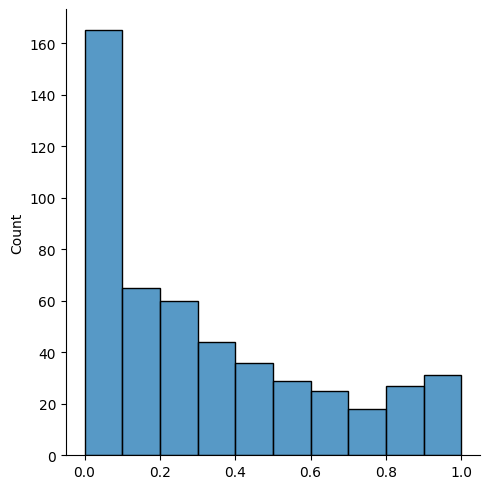

In [34]:
sns.displot(all_p[0])

Next we inspect the distribution of p-values for subsamples of size 400.  We see that the p-values are much more concentrated close to zero compared to when we had only 100 data points.  If we obtain a sample of size 400 from this population, we have around a 70% chance of obtaining a p-value smaller than 0.05, and are very unlikely to obtain a p-value greater than 0.4.

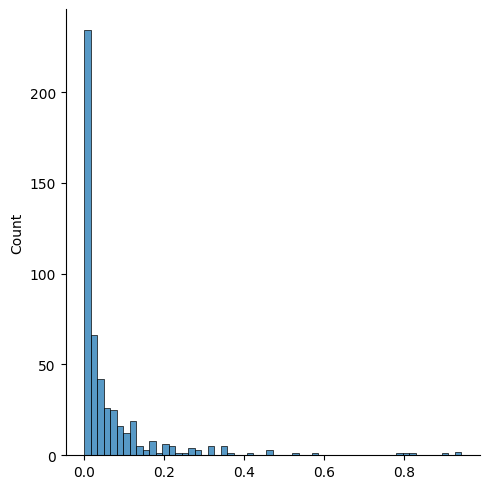

In [35]:
sns.displot(all_p[2])

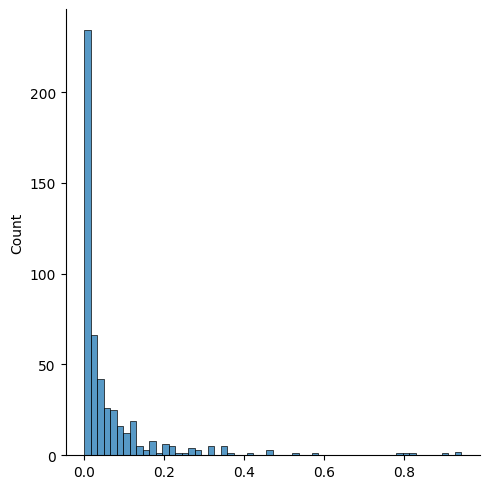

In [36]:
sns.displot(all_p[2])